In [1]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from collections import defaultdict
import pickle
from IPython.display import Video
rc('animation', html='jshtml')
sns.set_theme()

In [3]:
#@title Class definition
class Agent:
    """
    Agent class
    """
    
    # overwrite these
    _epsilon_init = 1
    _epsilon_decay = 0.99995
    _epsilon_min = 0.01
    _alpha = 0.1
    _gamma = 0.99
    _disc_step = 0.01

    def __init__(self, action_space : gym.Space):
        """
        Initializes the class

        Parameters:
            action_space : gym.Space
                action space for the environment
        """

        self._q_table = defaultdict(lambda: [0 for i in range(action_space.n)]) # for storing the q-values
        self._epsilon = self._epsilon_init                                      # for the ε-greedy
        self._as = action_space                                                 # action space

    def _discretize(self, state):
        """
        discretizes a state

        Parameters:
            state : array_like
                state to be discretized
        Returns:
            discretized_state : tuple
                discretized state
        """
        eta = 1/self._disc_step

        # rounding
        discretized_state = tuple( ( (state*eta).astype(np.int64).astype(np.double) / eta ).tolist() )
        return discretized_state

    def choose_action(self, state):
        """
        chooses the action for a given state

        Parametrs:
            state : array_like
                current state
        Returns
            action : int
                chosen action
        """
        self._epsilon = max(self._epsilon_decay * self._epsilon, self._epsilon_min)

        # chooses a random action
        if np.random.random() < self._epsilon:
            return self._as.sample()

        # chooses the highest value action
        state = self._discretize(state)
        q_values = self._q_table[state]
        highest_value_action = np.argmax(q_values)
        return highest_value_action

    def train(self, state, state_prime, action, reward, terminal):
        """
        Updates stored q-values
        
        Parameters:
            state : array_like
                previous state
            state_prime : array_like
                new state
            action : int
                action taken
            reward : int
                action reward
            terminal : bool
                True if the new state is a terminal state. False otherwise
        Returns:
            None
        """
        # gets discretized values
        state = self._discretize(state)
        state_prime = self._discretize(state_prime)

        # highest q-value for the next state
        highest_next_q_value = max(self._q_table[state_prime])

        # Bellman's equation
        self._q_table[state][action] = (1-self._alpha) * self._q_table[state][action] + \
                                            self._alpha*(reward + self._gamma * highest_next_q_value)
        
    def save(self, path):
        """
        saves the q-table at the designated path

        Parameters:
            path : str
                file path
        Returns:
            None
        """
        with open(path, 'wb') as handle:
            pickle.dump(dict(self._q_table), handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self._q_table)

In [5]:
# creating the environment
env = gym.make("CartPole-v1")

# helper function for visualizing the training
def avarage_reward(n, w):
    """
    for computing an avarage
    """

    if len(n) < w:
        return 0
    return np.convolve(n, np.ones(w)/w, 'valid')

class CartPoleAgent(Agent):

    # overwritten values
    _epsilon_init = 1
    _epsilon_decay = 0.999995
    _epsilon_min = 0.01
    _alpha = 0.1
    _gamma = 0.99
    _disc_step = np.array([0.25,0.25,0.01,0.01])


max_episodes = 60_000                                   # maximum number of episodes for this session of training
agent = CartPoleAgent(env.action_space)                 # initialing the agent
reward_history = np.zeros(max_episodes)                 # vector to hold the training rewads for later disaply
print("ep | rewards | moving avarage | len | epsilon")
print("")

for eps in range(max_episodes):

    # at the start of the episode
    terminal = False               # not a terminal state at the start                      
    state = env.reset()            # resets the environment
    episode_reward = 0             # resets the reward counter

    # during the episode
    while not terminal:            # while not at a terminal state
        action = agent.choose_action(state)                       # chooses the next action
        state_prime, reward, terminal, _ = env.step(action)       # gets the environment reaction
        agent.train(state, state_prime, action, reward, terminal) # trains the agent with this experience

        episode_reward += reward    # updates the reward counter
        state = state_prime         # the new state is now the current state
        
    
    # at the end of the episode
    save = False
    reward_history[eps] = episode_reward                        # updates the training rewards vector

    # displaying live episode data
    print(f"\r{eps} | {episode_reward} | {avarage_reward(reward_history[eps-50:eps], 50)} | {len(agent)} | {agent._epsilon}",end="")

# at the end of trainig, saves the q-values
agent.save("q_table.pickle")

ep | rewards | moving avarage | len | epsilon

59999 | 241.0 | [333.34] | 47814 | 0.01

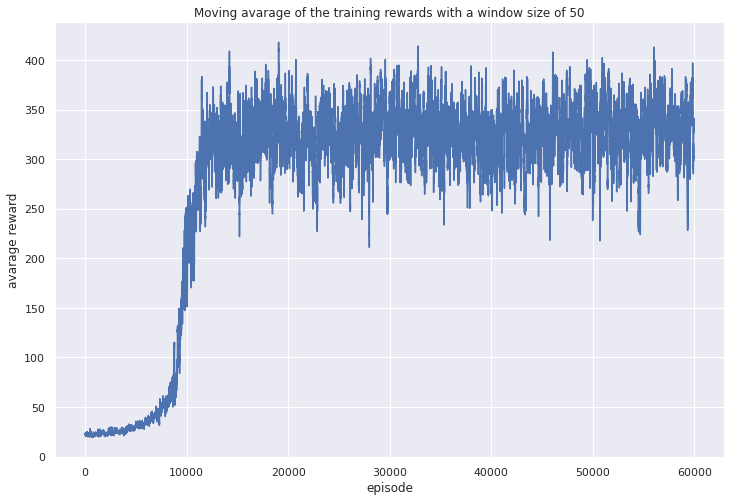

In [6]:
#@title Plot
plt.figure(figsize=(12,8))
plt.title("Moving avarage of the training rewards with a window size of 50")
plt.xlabel("episode")
plt.ylabel("avarage reward")
ma_50 = np.convolve(reward_history, np.ones(50)/50, mode="valid")
plt.plot(np.arange(len(ma_50)), ma_50)
plt.show()